In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from scipy import stats
%matplotlib inline
# import warnings; warnings.simplefilter('ignore')

In [22]:
study_rec = pd.read_csv('stud_math.csv')  # загрузить сырые данные
study_rec.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,...,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,...,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,...,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,...,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,...,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0


Примечание: В задаче сказано только про 29 столбцов - значит, имеем лишний столбец в данных.

## Первичная обработка данных

#### Соответствие структуры датасета

In [23]:
study_rec.columns  # визуальная проверка списка полей на предмет наличия лишних столбцов

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'studytime, granular', 'higher', 'internet', 'romantic', 'famrel',
       'freetime', 'goout', 'health', 'absences', 'score'],
      dtype='object')

In [24]:
study_rec.drop(['studytime, granular'], inplace=True,
               axis=1)  # удалить лишний столбец
print("Записей, всего:",len(study_rec))  # общее кол-во записей в датасете

Записей, всего: 395


### Чистка записей с пропусками

In [25]:
study_rec.isna().sum()  # какие столбцы содержат пропуски данных и сколько

school         0
sex            0
age            0
address       17
famsize       27
Pstatus       45
Medu           3
Fedu          24
Mjob          19
Fjob          36
reason        17
guardian      31
traveltime    28
studytime      7
failures      22
schoolsup      9
famsup        39
paid          40
activities    14
nursery       16
higher        20
internet      34
romantic      31
famrel        27
freetime      11
goout          8
health        15
absences      12
score          6
dtype: int64

In [26]:
before = len(study_rec)
study_rec = study_rec.dropna().reset_index()  # удалить записи с пропусками
study_rec.drop(['index'], inplace=True, axis=1)
after = len(study_rec) # кол-во записей без пропусков
print("До чистки:",before,"После чистки:",after)

До чистки: 395 После чистки: 97


### Валидация значений

In [27]:
# Задать правила валидации и допустимые значения для каждого поля
# - index - имя проверяемого поля в датасете
# - fld_type - тип поля
# - validate - требуется ли валидация для поля
# - val_range - диапазон допустимых значений для числового поля
# - val_list - список допустимых значений
val_rules = {
    'school': {'fld_type': 2, 'validate': 1, 'val_list': ['GP', 'MS'], 'val_range': [0,  0]},
    'sex': {'fld_type': 2, 'validate': 1, 'val_list': ['F', 'M'], 'val_range': [0,  0]},
    'age': {'fld_type': 1, 'validate': 1, 'val_list': list(range(15, 23)), 'val_range': [15,  23]},
    'address': {'fld_type': 2, 'validate': 1, 'val_list': ['U', 'R'], 'val_range': [0,  0]},
    'famsize': {'fld_type': 2, 'validate': 1, 'val_list': ['LE3', 'GT3'], 'val_range': [0,  0]},
    'Pstatus': {'fld_type': 2, 'validate': 1, 'val_list': ['T', 'A'], 'val_range': [0,  0]},
    'Medu': {'fld_type': 1, 'validate': 1, 'val_list': list(range(0, 5)), 'val_range': [0,  5]},
    'Fedu': {'fld_type': 1, 'validate': 1, 'val_list': list(range(0, 5)), 'val_range': [0,  5]},
    'Mjob': {'fld_type': 2, 'validate': 1, 'val_list': ['teacher', 'health', 'services', 'at_home', 'other'], 'val_range': [0,  0]},
    'Fjob': {'fld_type': 2, 'validate': 1, 'val_list': ['teacher', 'health', 'services', 'at_home', 'other'], 'val_range': [0,  0]},
    'reason': {'fld_type': 2, 'validate': 1, 'val_list': ['home', 'reputation', 'course', 'other'], 'val_range': [0,  0]},
    'guardian': {'fld_type': 2, 'validate': 1, 'val_list': ['mother', 'father', 'other'], 'val_range': [0,  0]},
    'traveltime': {'fld_type': 1, 'validate': 1, 'val_list': list(range(1, 5)), 'val_range': [1,  5]},
    'studytime': {'fld_type': 1, 'validate': 1, 'val_list': list(range(1, 5)), 'val_range': [1,  5]},
    'failures': {'fld_type': 1, 'validate': 1, 'val_list': list(range(0, 4)), 'val_range': [0,  4]},
    'schoolsup': {'fld_type': 2, 'validate': 1, 'val_list': ['yes', 'no'], 'val_range': [0,  0]},
    'famsup': {'fld_type': 2, 'validate': 1, 'val_list': ['yes', 'no'], 'val_range': [0,  0]},
    'paid': {'fld_type': 2, 'validate': 1, 'val_list': ['yes', 'no'], 'val_range': [0,  0]},
    'activities': {'fld_type': 2, 'validate': 1, 'val_list': ['yes', 'no'], 'val_range': [0,  0]},
    'nursery': {'fld_type': 2, 'validate': 1, 'val_list': ['yes', 'no'], 'val_range': [0,  0]},
    'higher': {'fld_type': 2, 'validate': 1, 'val_list': ['yes', 'no'], 'val_range': [0,  0]},
    'internet': {'fld_type': 2, 'validate': 1, 'val_list': ['yes', 'no'], 'val_range': [0,  0]},
    'romantic': {'fld_type': 2, 'validate': 1, 'val_list': ['yes', 'no'], 'val_range': [0,  0]},
    'famrel': {'fld_type': 1, 'validate': 1, 'val_list': list(range(1, 6)), 'val_range': [1,  6]},
    'freetime': {'fld_type': 1, 'validate': 1, 'val_list': list(range(1, 6)), 'val_range': [1,  6]},
    'goout': {'fld_type': 1, 'validate': 1, 'val_list': list(range(1, 6)), 'val_range': [1,  6]},
    'health': {'fld_type': 1, 'validate': 1, 'val_list': list(range(1, 6)), 'val_range': [1,  6]},
    'absences': {'fld_type': 1, 'validate': 0, 'val_list': list(range(0, 41, 5)), 'val_range': [0,  41]},
    'score': {'fld_type': 1, 'validate': 0, 'val_list': list(range(0, 100, 10)), 'val_range': [0, 100]}
}

In [28]:
# обход по полям датасета и валидация (если предусмотрена)
for fld, params in val_rules.items():
    if params["validate"] == 1:  # если предполагается валидация поля
        study_rec[fld] = study_rec[fld].apply(
            lambda x: x if x in params["val_list"] else None)  # все ошибки валидации заменить на None

### Повторная чистка записей с пропусками

Примечание: повторная чистка пропусков сделана сознательно, чтобы оценить кол-во значений, проваливших валидацию данных

In [29]:
study_rec.isna().sum()  # какие столбцы содержат пропуски данных и сколько

school        0
sex           0
age           0
address       0
famsize       0
Pstatus       0
Medu          0
Fedu          0
Mjob          0
Fjob          0
reason        0
guardian      0
traveltime    0
studytime     0
failures      0
schoolsup     0
famsup        0
paid          0
activities    0
nursery       0
higher        0
internet      0
romantic      0
famrel        0
freetime      0
goout         0
health        0
absences      0
score         0
dtype: int64

In [30]:
before = len(study_rec)
study_rec = study_rec.dropna().reset_index()  # удалить записи с пропусками
study_rec.drop(['index'], inplace=True, axis=1)
after = len(study_rec) # кол-во записей без пропусков
print("До чистки:",before,"После чистки:",after)

До чистки: 97 После чистки: 97


## Устранение выбросов числовых параметров

Числовые параметры:
    
* `age` — возраст ученика (от 15 до 22)
* `Medu` — образование матери (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)
* `Fedu` — образование отца (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)
* `traveltime` — время в пути до школы (1 - <15 мин., 2 - 15-30 мин., 3 - 30-60 мин., 4 - >60 мин.)
* `studytime` — время на учёбу помимо школы в неделю (1 - <2 часов, 2 - 2-5 часов, 3 - 5-10 часов, 4 - >10 часов)
* `failures` — количество внеучебных неудач (n, если 1<=n<=3, иначе 0)
* `famrel` — семейные отношения (от 1 - очень плохо до 5 - очень хорошо)
* `freetime` — свободное время после школы (от 1 - очень мало до 5 - очень мого)
* `goout` — проведение времени с друзьями (от 1 - очень мало до 5 - очень много)
* `health` — текущее состояние здоровья (от 1 - очень плохо до 5 - очень хорошо)
* `absences` — количество пропущенных занятий
* `score` — баллы по госэкзамену по математике

In [31]:
# Исключить из датасета записи с числовыми выбросами
# col_name - название столбца, по которому фильтруем выбросы
# kick - флаг удаления записей, содержащих выбросы
#  * True - удалять записи с выбросами
#  * False - (по умолчанию) только фильтровать для визуализации
def kick_outliners(col_name, kick=False):
    global study_rec

    IQR = study_rec[col_name].quantile(0.75) - study_rec[col_name].quantile(0.25)
    perc25 = study_rec[col_name].quantile(0.25) # 25 персентиль
    perc75 = study_rec[col_name].quantile(0.75) # 75 персентиль
    outliners = len(study_rec[(study_rec[col_name] < (perc25 - 1.5*IQR)) | (study_rec[col_name] > (perc75 + 1.5*IQR))]) # подсчет кол-ва выбросов по полю
    print(col_name, ': 25% [{},'.format(perc25), '--- {}] 75%,'.format(perc75),
          "IQR: {}, ".format(IQR), "Границы выбросов: [{f}, {l}], ".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR), "Выбросы: ", outliners)

    study_rec[col_name].loc[study_rec[col_name].between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)].hist(figsize=(10, 6), bins=len(
        val_rules[col_name]["val_list"]), range=(val_rules[col_name]["val_range"][0], val_rules[col_name]["val_range"][1]), label='IQR')
    plt.legend()

    if kick == True:  # удалить из датасета записи с выбросами по указанному полю
        study_rec = study_rec.loc[study_rec[col_name].between(
            perc25 - 1.5*IQR, perc75 + 1.5*IQR)]
    return

In [12]:
check_var="famrel"
study_rec[check_var].describe()

count    97.000000
mean      3.917526
std       0.897567
min       1.000000
25%       4.000000
50%       4.000000
75%       4.000000
max       5.000000
Name: famrel, dtype: float64

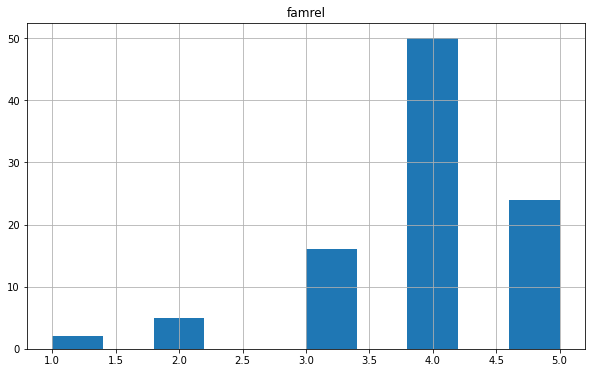

In [13]:
study_rec.hist(column=check_var, figsize=(10, 6));

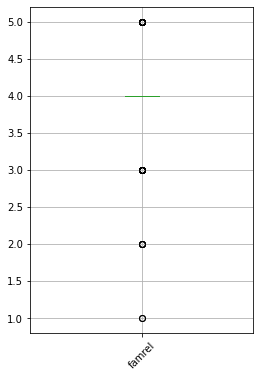

In [14]:
study_rec.boxplot(column=check_var, figsize=(4, 6), rot=45);

famrel : 25% [4.0, --- 4.0] 75%, IQR: 0.0,  Границы выбросов: [4.0, 4.0],  Выбросы:  47


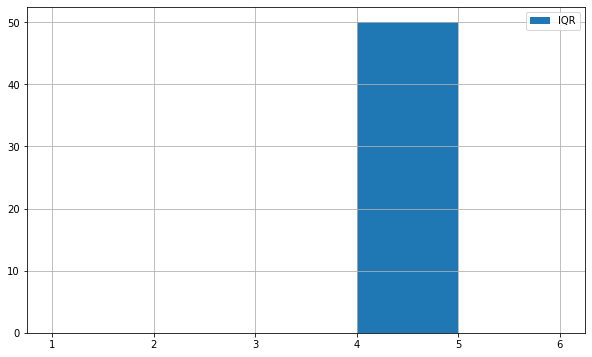

In [15]:
kick_outliners(check_var)

age : 25% [16.0, --- 18.0] 75%, IQR: 2.0,  Границы выбросов: [13.0, 21.0],  Выбросы:  1
Medu : 25% [2.0, --- 4.0] 75%, IQR: 2.0,  Границы выбросов: [-1.0, 7.0],  Выбросы:  0
Fedu : 25% [2.0, --- 4.0] 75%, IQR: 2.0,  Границы выбросов: [-1.0, 7.0],  Выбросы:  0
traveltime : 25% [1.0, --- 2.0] 75%, IQR: 1.0,  Границы выбросов: [-0.5, 3.5],  Выбросы:  1
studytime : 25% [2.0, --- 3.0] 75%, IQR: 1.0,  Границы выбросов: [0.5, 4.5],  Выбросы:  0
failures : 25% [0.0, --- 0.0] 75%, IQR: 0.0,  Границы выбросов: [0.0, 0.0],  Выбросы:  18
famrel : 25% [4.0, --- 5.0] 75%, IQR: 1.0,  Границы выбросов: [2.5, 6.5],  Выбросы:  5
freetime : 25% [3.0, --- 4.0] 75%, IQR: 1.0,  Границы выбросов: [1.5, 5.5],  Выбросы:  4
goout : 25% [2.0, --- 4.0] 75%, IQR: 2.0,  Границы выбросов: [-1.0, 7.0],  Выбросы:  0
health : 25% [2.0, --- 5.0] 75%, IQR: 3.0,  Границы выбросов: [-2.5, 9.5],  Выбросы:  0
absences : 25% [0.0, --- 6.25] 75%, IQR: 6.25,  Границы выбросов: [-9.375, 15.625],  Выбросы:  4
score : 25% [50.0, -

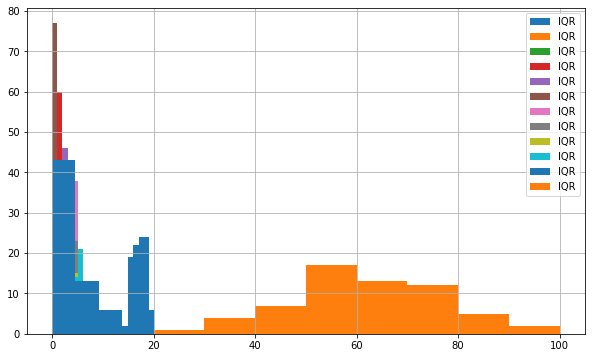

In [33]:
# обход по полям датасета и проверка на выбросы
before = len(study_rec)
for fld, params in val_rules.items():
    if params["fld_type"] == 1:  # проверяем на выбросы только числовые поля
        kick_outliners(fld, True)
after = len(study_rec)
print("До чистки:",before,"После чистки:",after)

## Оценка уникальных значений номинативных параметров

In [34]:
# Показать распределение уникальных значений номинативных параметров
# - col_name - название поля
def display_nominatives(col_name):
    global study_rec

    display(pd.DataFrame([study_rec[col_name].value_counts(
    ), study_rec[col_name].value_counts(normalize=True)*100], index=[col_name, '%%']))
    return

In [35]:
# обход по номинативным полям датасета и формирование распределения уникальных значений
for fld, params in val_rules.items():
    if params["fld_type"] == 2:
        display_nominatives(fld)

,GP,MS
school,52.000000,9.000000
%%,85.245902,14.754098


,F,M
sex,33.000000,28.000000
%%,54.098361,45.901639


,U,R
address,51.000000,10.000000
%%,83.606557,16.393443


,GT3,LE3
famsize,38.000000,23.000000
%%,62.295082,37.704918


,T,A
Pstatus,54.00000,7.00000
%%,88.52459,11.47541


,other,services,teacher,health,at_home
Mjob,26.000000,13.000000,12.000000,6.000000,4.000000
%%,42.622951,21.311475,19.672131,9.836066,6.557377


,other,services,health,teacher,at_home
Fjob,32.000000,18.000000,4.000000,4.000000,3.000000
%%,52.459016,29.508197,6.557377,6.557377,4.918033


,course,reputation,home,other
reason,24.000000,22.000000,10.000000,5.000000
%%,39.344262,36.065574,16.393443,8.196721


,mother,father,other
guardian,42.000000,16.000000,3.000000
%%,68.852459,26.229508,4.918033


,no,yes
schoolsup,53.000000,8.000000
%%,86.885246,13.114754


,yes,no
famsup,35.000000,26.000000
%%,57.377049,42.622951


,yes,no
paid,36.000000,25.000000
%%,59.016393,40.983607


,yes,no
activities,33.000000,28.000000
%%,54.098361,45.901639


,yes,no
nursery,50.000000,11.000000
%%,81.967213,18.032787


,yes
higher,61.0
%%,100.0


,yes,no
internet,54.00000,7.00000
%%,88.52459,11.47541


,no,yes
romantic,38.000000,23.000000
%%,62.295082,37.704918


# Корреляционный анализ

In [36]:
# Построение списков числовых и строковых полей
fld_numerics = []  # числовые поля
fld_string = []  # строковые поля
for fld, params in val_rules.items():
    if params["fld_type"] == 1:
        fld_numerics.append(fld)
    else:
        fld_string.append(fld)
print("Числовые поля:", fld_numerics)
print("Номинативные поля:", fld_string)

Числовые поля: ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'health', 'absences', 'score']
Номинативные поля: ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']


In [37]:
study_rec[fld_numerics].corr() # корреляция числовых полей

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,health,absences,score
age,1.000000,0.013108,0.059885,0.242272,-0.208696,NaN,0.116361,-0.059299,0.054430,0.102753,-0.021926,-0.115607
Medu,0.013108,1.000000,0.673525,-0.131807,0.092869,NaN,0.132238,-0.115951,-0.108249,-0.064649,0.272807,-0.061079
Fedu,0.059885,0.673525,1.000000,0.007244,-0.057103,NaN,0.024605,-0.163589,-0.107304,0.093642,0.158261,-0.080341
traveltime,0.242272,-0.131807,0.007244,1.000000,-0.046635,NaN,-0.136677,0.010523,-0.073445,0.206324,0.025989,-0.184462
studytime,-0.208696,0.092869,-0.057103,-0.046635,1.000000,NaN,0.069054,-0.089676,-0.007911,-0.121259,0.058841,0.195821
failures,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
famrel,0.116361,0.132238,0.024605,-0.136677,0.069054,NaN,1.000000,0.098031,0.062187,0.171955,-0.112351,0.051750
freetime,-0.059299,-0.115951,-0.163589,0.010523,-0.089676,NaN,0.098031,1.000000,0.261026,0.040758,0.131033,0.030477
goout,0.054430,-0.108249,-0.107304,-0.073445,-0.007911,NaN,0.062187,0.261026,1.000000,0.037668,-0.037862,-0.163127
health,0.102753,-0.064649,0.093642,0.206324,-0.121259,NaN,0.171955,0.040758,0.037668,1.000000,0.061472,-0.039712


In [38]:
# Визуализация зависимости номинативных полей и результатов экзаменов
def get_boxplot(col_name):
    fig, ax = plt.subplots(figsize=(14, 4))
    sns.boxplot(x=col_name, y='score', data=study_rec.loc[study_rec.loc[:, col_name].isin(
        study_rec.loc[:, col_name].value_counts().index[:])], ax=ax)
    plt.xticks(rotation=45)
    ax.set_title(col_name)
    plt.show()

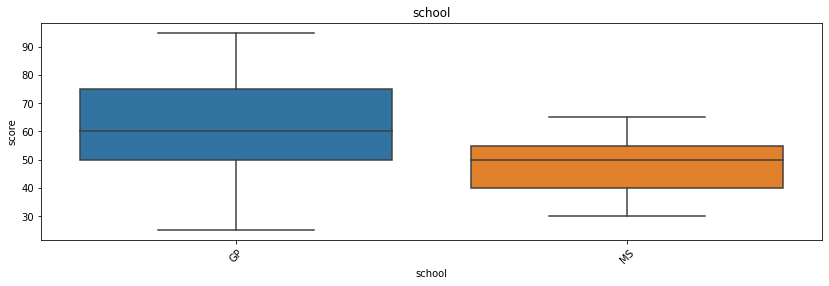

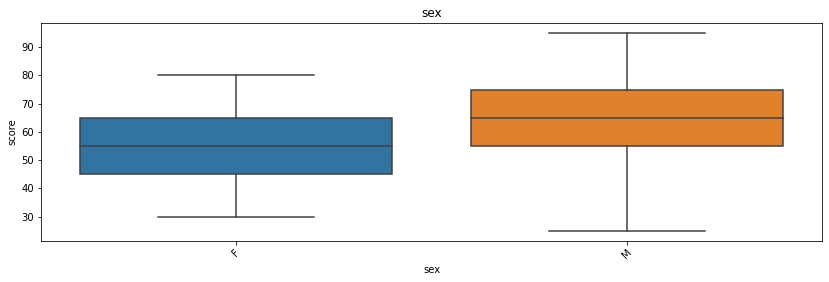

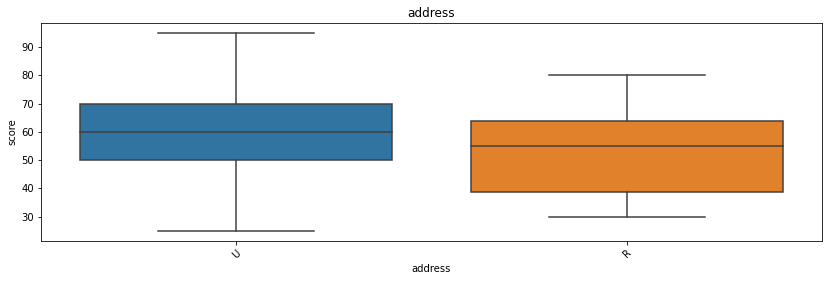

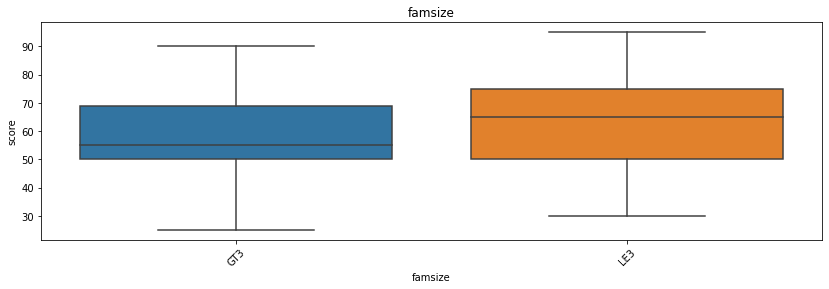

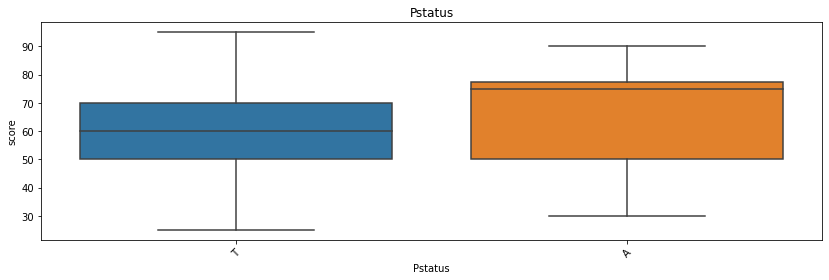

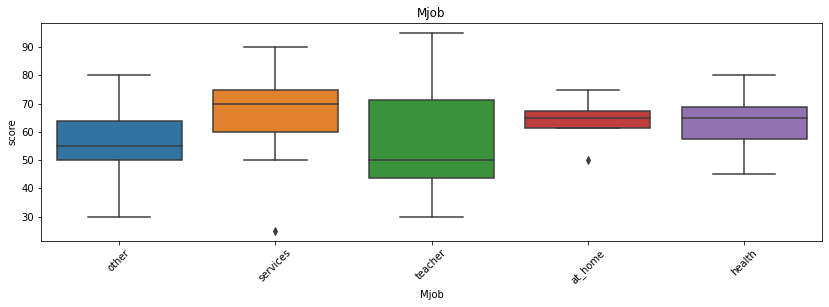

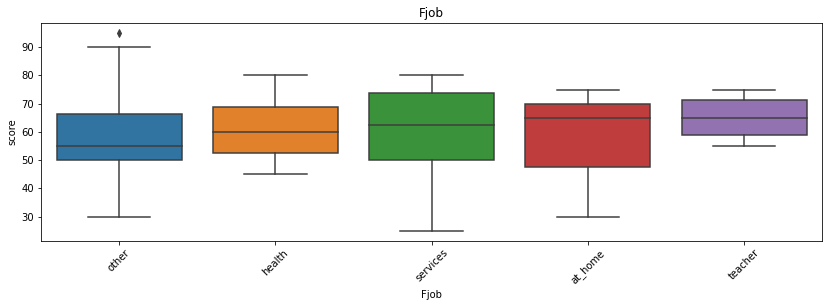

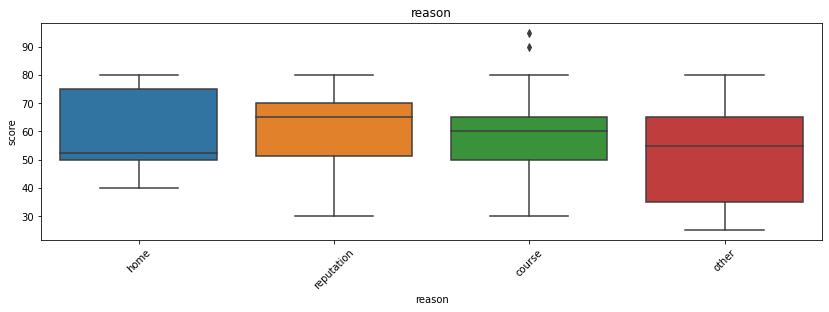

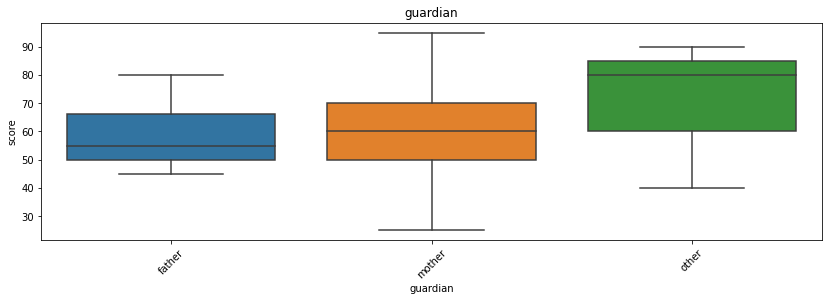

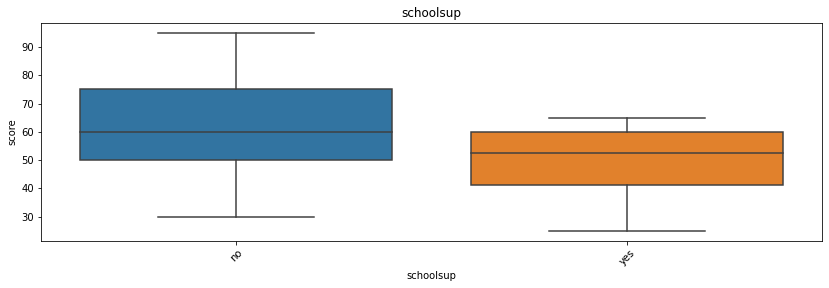

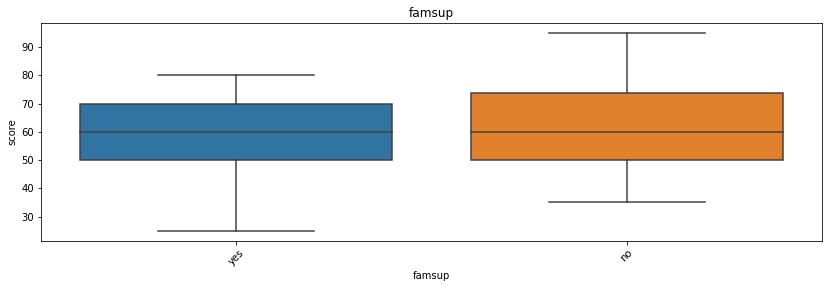

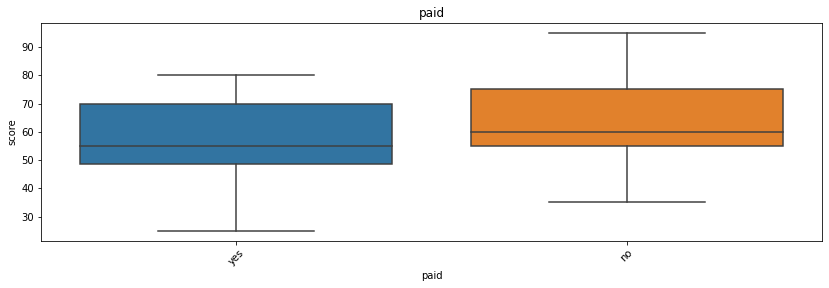

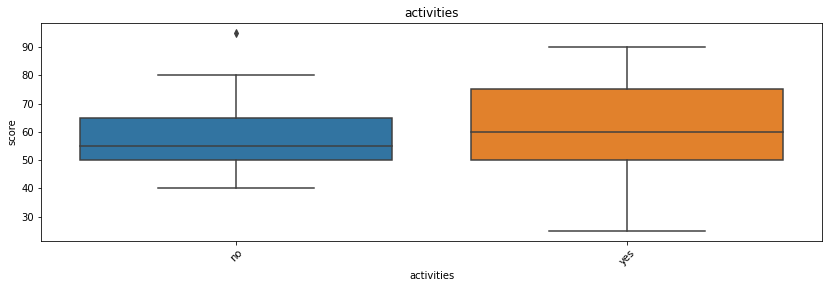

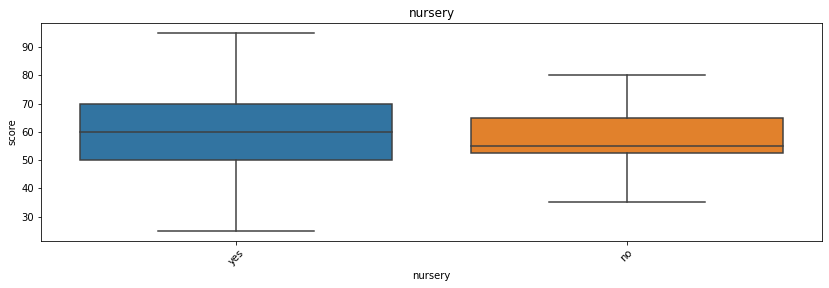

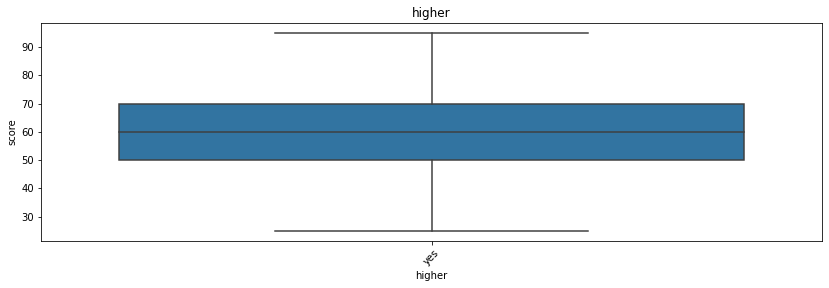

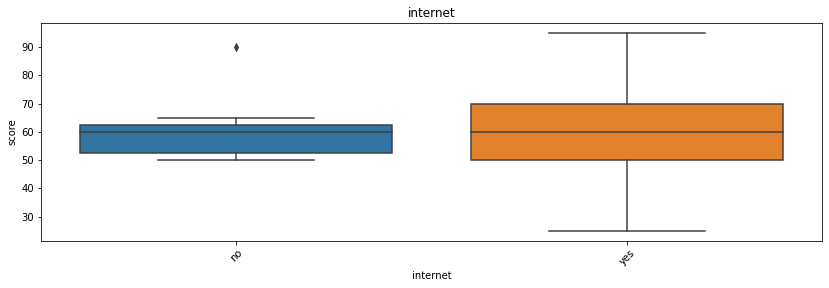

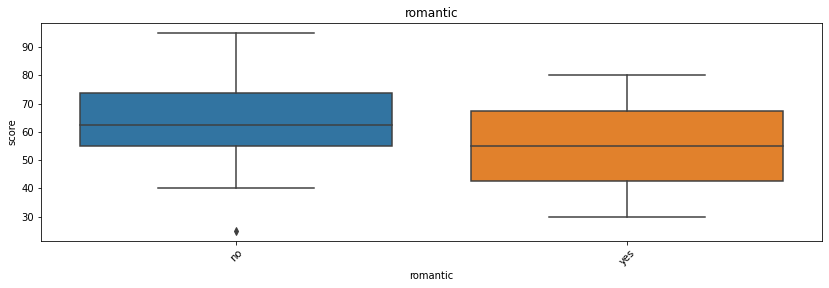

In [39]:
for fld in fld_string:
    get_boxplot(fld)

In [40]:
# Тест Стьюдента
def get_stat_dif(col_name):
    cols = study_rec.loc[:, col_name].value_counts().index[:]
    combinations_all = list(itertools.combinations(cols, 2))
    for comb in combinations_all:
        if stats.ttest_ind(study_rec.loc[study_rec.loc[:, col_name] == comb[0], 'score'],
                     study_rec.loc[study_rec.loc[:, col_name] == comb[1], 'score']).pvalue \
                <= 0.05/len(combinations_all):  # Учли поправку Бонферони
            print('Найдены статистически значимые различия для столбца', col_name)
            break

In [41]:
# Выполнить тест Стьюдента для номинативных параметров
for fld in fld_string:
    get_stat_dif(fld)

Найдены статистически значимые различия для столбца school
Найдены статистически значимые различия для столбца sex
Найдены статистически значимые различия для столбца schoolsup


## Выводы

In [42]:
# Формирование итоговой таблицы значений для построения модели
study_rec_model = study_rec.loc[:, ['age', 'Medu', 'traveltime', 'studytime', 'failures', 'famrel',
                                    'freetime', 'goout', 'health', 'absences', 'sex', 'address', 'schoolsup']]
study_rec_model.head()

,age,Medu,traveltime,studytime,failures,famrel,freetime,goout,health,absences,sex,address,schoolsup
0,16,3.0,1.0,2.0,0.0,4.0,3.0,2.0,5.0,4.0,F,U,no
1,16,4.0,1.0,2.0,0.0,5.0,4.0,2.0,5.0,10.0,M,U,no
3,15,4.0,1.0,2.0,0.0,3.0,3.0,3.0,2.0,0.0,F,U,no
4,15,2.0,1.0,3.0,0.0,4.0,5.0,2.0,3.0,0.0,M,U,no
5,16,4.0,1.0,3.0,0.0,3.0,2.0,3.0,2.0,6.0,F,U,no


## Попытка улучшения данных
### Повторная загрузка датасета без чистки пропусков несущественных полей

In [43]:
study_rec = pd.read_csv('stud_math.csv')  # загрузить сырые данные
study_rec.head()
study_rec.drop(['studytime, granular', 'school', 'famsize', 'Pstatus', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic'], inplace=True,
               axis=1)  # удалить лишний столбец
print("Записей, всего:", len(study_rec))  # общее кол-во записей в датасете
before = len(study_rec)
study_rec = study_rec.dropna().reset_index()  # удалить записи с пропусками
study_rec.drop(['index'], inplace=True, axis=1)
after = len(study_rec)  # кол-во записей без пропусков
print("До чистки:", before, "После чистки:", after)
study_rec.head()

Записей, всего: 395
До чистки: 395 После чистки: 260


,sex,age,address,Medu,traveltime,studytime,failures,schoolsup,famrel,freetime,goout,health,absences,score
0,F,18,U,4.0,2.0,2.0,0.0,yes,4.0,3.0,4.0,3.0,6.0,30.0
1,F,17,U,1.0,1.0,2.0,0.0,no,5.0,3.0,3.0,3.0,4.0,30.0
2,F,15,U,1.0,1.0,2.0,3.0,yes,4.0,3.0,2.0,3.0,10.0,50.0
3,F,15,U,4.0,1.0,3.0,0.0,no,3.0,2.0,2.0,5.0,2.0,75.0
4,F,16,U,3.0,1.0,2.0,0.0,no,4.0,3.0,2.0,5.0,4.0,50.0


## Дополнительные комментарии

1. К сожалению, построение графиков пока что остаётся чёрным ящиком - этот кусок надо продолжить изучать
1. Функцию для проведения теста Стьюдента скопировал из пособия без детального понимания - надо будет к этому также вернуться еще
1. До сих пор не могу понять, как оценивается время выполнения задания - мои затраты времени существенно превысили оценочные. Возможно, это связано с тем, что Python продолжает для меня оставаться "неродным" языком. Плюс недостаток практики.
1. Задание понравилось, потратил на него времени гораздо больше, но получил удовольствие от процесса.
1. autopep8 оставил неоднозначные впечатления - в простых случаях он вроде бы форматирует текст, но лишние пробелы при этом не убирает, переносы строк также расставляет неочевидно. Если есть какой-то более продуманный инструмент, буду признателен за информацию о нём.